# Tweets analysis

This notebook is used to analyse tweets.

Note that this it requires already downloaded (and pre-processed) tweets. This can be done by using twitterDownloader.ipynb (and twitterFilterer.ipynb).

In [426]:
import codecs
import json
from collections import Counter

import nltk
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import TwitterProcessing

# nltk.download('vader_lexicon')
# nltk.download('stopwords')

from wordcloud import WordCloud
import string
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import warnings
import ssl

import pyLDAvis
from pyLDAvis import lda_model

from time import strptime
from datetime import datetime
from time import mktime

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [427]:
nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [428]:
# There are some warnings with LDA which we want to ignore
warnings.filterwarnings('ignore')

In [429]:
def process_tweet(text, tokenizer=nltk.tokenize.TweetTokenizer(), stemmer=nltk.stem.PorterStemmer(), stopwords=[]):
    """
    Perform tokenization, normalisation (lower case and stemming) and stopword and twitter keyword removal.

    @param text: tweet text
    @param tokenizer: tokenizer used.
    @param stemmer: stemmer used.
    @param stopwords: list of stopwords used

    @returns: a list of processed tokens
    """
    # covert all to lower case
    text = text.lower()

    # tokenize
    tokens = tokenizer.tokenize(text)

    # strip whitespaces before and after
    tokens = [token.strip() for token in tokens]

    # stem (we use set to remove duplicates)
    stemmed_tokens = set([stemmer.stem(tok) for tok in tokens])

    # remove stopwords, digits
    return [tok for tok in stemmed_tokens if tok not in stopwords and not tok.isdigit()]

In [430]:
def load_words(filename):
    """
    Loads the worlds of the file with the given name to a set.
    :param filename: The name of the file to load the words from.
    :return: A set of words loaded from the file.
    """
    words = []
    with codecs.open(filename, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            words.append(line.strip())

    return set(words)

In [431]:
def load_tweets(filename):
    """
    Loads the tweets from the file with the given name into an array of tweets.

    @param filename: The filename of the file to load the tweets from.

    @returns: An array of tweets.
    """
    tweets = []
    with open(filename, 'r') as f:
        for sLine in f:
            tweet = json.loads(sLine)
            tweets.append(tweet)
    return tweets

In [432]:
def get_hashtags(tweet):
    """
    Extracts the associated hashtags of tweet.

    @param tweet: The tweet, which is in the tweepy json format, and which we wish to extract its associated hashtags.

    @returns: list of hashtags (in lower case)
    """
    entities = tweet.get('entities', {})
    hashtags = entities.get('hashtags', [])

    return [tag['tag'].lower() for tag in hashtags]

In [433]:
# Name of the json file with the tweets to process
tweets_filename = '../data/coronation_2023_05_05_filtered.json'

# number of hashtags to display
hashtag_trash = 50

# number of most used words to display
words_trash = 50

# Load the tweets
tweets = load_tweets(tweets_filename)
print(len(tweets))

36479


In [434]:
# Get the total number of tweets.
print("Total number of tweets: ", len(tweets))

first_created_at = tweets[0].get('created_at', '')
for tweet in tweets:
    created_at = tweet.get('created_at', '')
    if created_at is not None or first_created_at < created_at:
        last_created_at = created_at
print("First tweets date: ", first_created_at)

last_created_at = tweets[0].get('created_at', '')
for tweet in tweets:
    created_at = tweet.get('created_at', '')
    if created_at is not None and last_created_at > created_at:
        last_created_at = created_at
print("Last tweets date: ", last_created_at)

first_datetime = datetime.fromtimestamp(mktime(strptime(first_created_at, "%Y-%m-%dT%H:%M:%S.000Z")))
last_datetime = datetime.fromtimestamp(mktime(strptime(last_created_at, "%Y-%m-%dT%H:%M:%S.000Z")))

timediff =  first_datetime - last_datetime
print("Time difference: " + timediff.__str__())

tweets_per_second = len(tweets)/timediff.total_seconds()
print("Tweets per second: " + tweets_per_second.__str__())

seconds_per_week = 604800
estimated_max_timeframe_tweets = int(tweets_per_second * seconds_per_week)
print("Tweet estimation for one week: " + estimated_max_timeframe_tweets.__str__())

seconds_per_day = 86400
estimated_tweets_per_day = int(tweets_per_second * seconds_per_day)
print("Tweet estimation for one day " + estimated_tweets_per_day.__str__())

Total number of tweets:  36479
First tweets date:  2023-05-05T23:57:37.000Z
Last tweets date:  2023-05-05T00:00:01.000Z
Time difference: 23:57:36
Tweets per second: 0.42291550732702654
Tweet estimation for one week: 255779
Tweet estimation for one day 36539


## Keyword and hashtag analysis

In [435]:
# Use a counter for counting hashtags
hashtag_counter = Counter()

# Add hashtags to counter
for tweet in tweets:
    hashtagsInTweet = get_hashtags(tweet)
    hashtag_counter.update(hashtagsInTweet)

# Print most used hashtags
for tag, count in hashtag_counter.most_common(hashtag_trash):
    print(tag + ": " + str(count))

coronation: 7545
kingcharles: 2838
kingcharlesiii: 970
coronationweekend: 941
kingcharlescoronation: 812
coronation2023: 795
kingscoronation: 404
uk: 316
royalfamily: 308
london: 292
king: 271
art: 241
homedecor: 226
news: 223
charles: 220
bankholiday: 211
fridayfeeling: 187
friday: 184
vintage: 179
coronationday: 176
rediscova: 175
notmyking: 172
interiordesign: 171
interiors: 170
interiorstyling: 170
tableware: 169
studioglass: 169
giftideas: 169
onelove: 169
charlesiii: 160
royal: 159
queencamilla: 158
kingcharlesiiicoronation: 148
godsavetheking: 140
coronationconcert: 136
pottery: 134
breakingnews: 126
celebration: 112
monarchy: 101
royalty: 101
britain: 95
buckinghampalace: 93
coronationbiglunch: 88
england: 84
ceramics: 83
bankholidayweekend: 80
royals: 79
abolishthemonarchy: 78
princeharry: 75
antiques: 73


In [436]:
# Tweet tokenizer to use
tweet_tokenizer = nltk.tokenize.TweetTokenizer()

# Use the punctuation symbols defined in string.punctuation
puncts = list(string.punctuation)

# Use stopwords from nltk and a few other twitter specific terms
twitter_stopwords = ['...', '…', '"', "'", '`', '‘', '“', '”',' ','re']
web_stopwords = ['uk','🇬','🇧','https','co']
all_stopwords = nltk.corpus.stopwords.words('english')\
                + twitter_stopwords\
                + web_stopwords \
                + puncts
stopwords = list(dict.fromkeys(all_stopwords))

# Use the popular Porter stemmer
tweet_stemmer = nltk.stem.PorterStemmer()

# The term frequency counter
word_counter = Counter()

In [437]:
tweet_text_processed = []
for tweet in tweets:
    tweet_text = tweet.get('text', '')

    # Tokenize, filter stopwords and get convert to lower case
    tokens = process_tweet(text=tweet_text, tokenizer=tweet_tokenizer, stemmer=tweet_stemmer, stopwords=stopwords)
    tweet_text_processed.append(' '.join(tokens))

    # Update counter
    word_counter.update(tokens)

# Print out most common terms
for term, count in word_counter.most_common(words_trash):
    print(term + ': ' + str(count))

charl: 26944
coron: 25823
king: 24665
iii: 11972
rt: 8547
#coron: 7519
’: 7409
celebr: 5569
hi: 4358
thi: 4228
👑: 3119
queen: 3038
royal: 3029
#kingcharl: 2838
weekend: 2744
may: 2490
tomorrow: 2446
day: 2346
crown: 2258
ha: 2113
camilla: 1994
london: 1935
watch: 1823
ahead: 1760
saturday: 1682
majesti: 1611
attend: 1594
time: 1557
princ: 1459
via: 1452
new: 1434
wa: 1417
today: 1415
british: 1407
year: 1360
ceremoni: 1348
iii': 1346
us: 1326
event: 1282
look: 1178
take: 1174
enjoy: 1149
live: 1110
like: 1067
parti: 1063
mark: 1023
special: 1012
holiday: 1012
peopl: 1004
wish: 997


## Sentiment Analysis

In [438]:
def vader_sentiment_analysis(tweet_filename, tweet_processor, preprocess_words=True):
    """
    Use Vader lexicons instead of a raw positive and negative word count.

    @param tweet_filename: name of input file containing a json formatted tweet dump
    @param tweet_processor: TweetProcessing object, used to pre-process each tweet.
    @param preprocess_words: Whether the words should be preprocessed before analysis or not.

    @returns: list of tweets, in the format of [date, sentiment]
    """
    # this is the vader sentiment analyser, part of nltk
    sent_analyser = SentimentIntensityAnalyzer()

    sentiments = []
    # open file and process tweets, one by one
    with open(tweet_filename, 'r') as f:
        for line in f:
            # each line is loaded according to json format, into tweet, which is actually a dictionary
            tweet = json.loads(line)

            try:
                tweet_text = tweet.get('text', '')
                tweet_date = tweet.get('created_at')

                # pre-process the tweet text
                if preprocess_words:
                    tokens = tweet_processor.process(tweet_text)
                else:
                    tokens = tweet_text

                # this computes the sentiment scores (called polarity score in nltk, but mean same thing essentially)
                # see lab sheet for what dSentimentScores holds
                if preprocess_words:
                    sentiment_scores = sent_analyser.polarity_scores(" ".join(tokens))
                else:
                    sentiment_scores = sent_analyser.polarity_scores(tokens)

                # save the date and sentiment of each tweet (used for time series)
                sentiments.append([pd.to_datetime(tweet_date), sentiment_scores['compound']])

            except KeyError as e:
                pass

    return sentiments

In [440]:
# call the TwitterProcessing python script
tweet_processor = TwitterProcessing.TwitterProcessing(tweet_tokenizer, stopwords)

In [441]:
# compute the sentiment
sentiments = vader_sentiment_analysis(tweets_filename, tweet_processor, False)

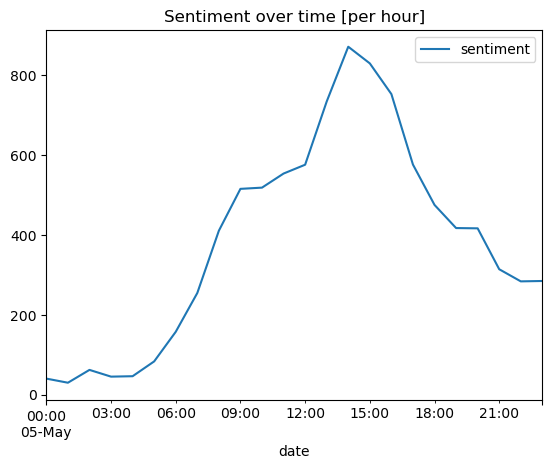

In [442]:
# Visualize the gathered data
series = pd.DataFrame(sentiments, columns=['date', 'sentiment'])
series.set_index('date', inplace=True)
series[['sentiment']] = series[['sentiment']].apply(pd.to_numeric)

series = series.resample('1h').sum() # mean
series.plot()
plt.title("Sentiment over time [per hour]")
plt.show()

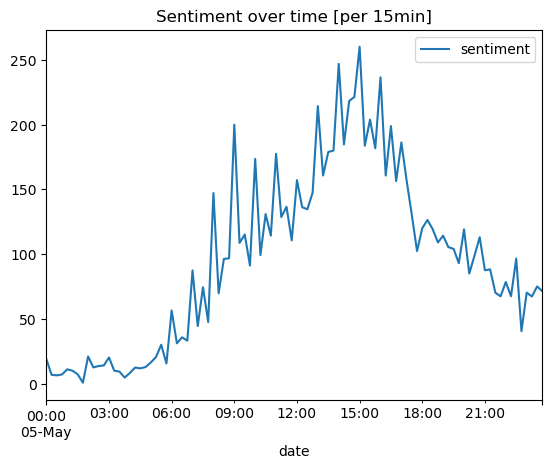

In [443]:
# Visualize the gathered data
# pd.date_range("2022-10-06", "2022-10-07")

series = pd.DataFrame(sentiments, columns=['date', 'sentiment'])
series[['sentiment']] = series[['sentiment']].apply(pd.to_numeric)

series.set_index('date', inplace=True)


series = series.resample('15min').sum()
series.plot()
plt.title("Sentiment over time [per 15min]")
plt.show()

## Topic analysis

In [444]:
def display_topics(model, feature_names, words_to_print_per_topic):
    """
    Prints out the most associated words for each feature.

    @param model: lda model.
    @param feature_names: list of strings, representing the list of features/words.
    @param words_to_print_per_topic: number of words to print per topic.
    """

    # print out the topic distributions
    for topic_id, topic_distribution in enumerate(model.components_):
        print("Topic %d:" % (topic_id+1))
        print(" ".join([feature_names[i] for i in topic_distribution.argsort()[:-words_to_print_per_topic - 1:-1]]))

def display_word_crowd(model, feature_names):
    """
    Displays the word cloud of the topic distributions of the model.

    @param model: The LDA model.
    @param feature_names: list of strings, representing the list of features/words.
    """

    # normalize each row/topic to sum to one
    normalised_components = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]

    # Display a wordcrowd for each topic
    for topic_id, topic_distribution in enumerate(normalised_components):
        word_probabilities = {feature_names[i] : wordProb for i, wordProb in enumerate(topic_distribution)}
        wordcloud = WordCloud(background_color='black')
        wordcloud.fit_words(frequencies=word_probabilities)
        plt.title('Topic %d:' % (topic_id+1))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show(block=True)

In [445]:
# number of topics to discover (default = 10)
number_of_topics = 5

# maximum number of words to display per topic (default = 10)
words_to_display_per_topic = 10

# number of features/words to describe our documents
number_of_features = 1500

# extract a document-term matrix and the feature names using a CountVectorizer to do counting
vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=number_of_features, stop_words=stopwords)
document_term_matrix = vectorizer.fit_transform(tweet_text_processed)

# extract the names of the features (= words)
feature_names = vectorizer.get_feature_names_out()

In [446]:
# train LDA model with the data
model = LatentDirichletAllocation(n_components=number_of_topics, max_iter=10, learning_method='online').fit(document_term_matrix)

In [447]:
# Print the most common words per topic.
display_topics(model, feature_names, words_to_display_per_topic)

Topic 1:
co https coron king charl iii kingcharl via royal watch
Topic 2:
coron charl king rt may thi holiday bank iii mark
Topic 3:
coron king charl celebr iii rt thi hi weekend queen
Topic 4:
coron charl king attend rt london presid coronationweekend coronation2023 first
Topic 5:
coron royal hi famili year queen rt head charl elizabeth


In [448]:
# Visualize using pyLDAvis
panel = pyLDAvis.lda_model.prepare(model, document_term_matrix ,vectorizer, mds='tsne')
pyLDAvis.display(panel)

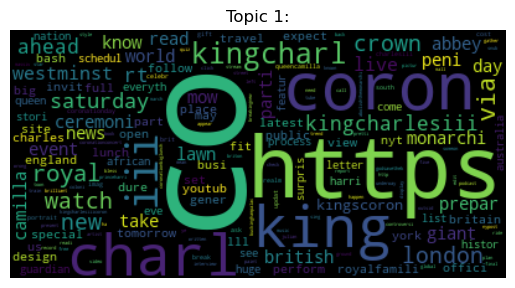

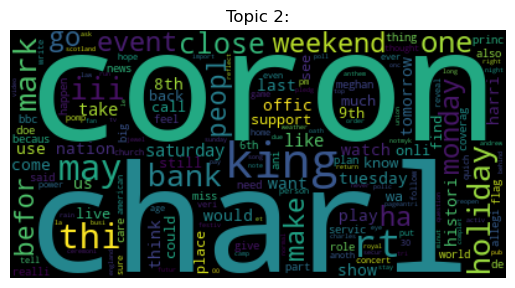

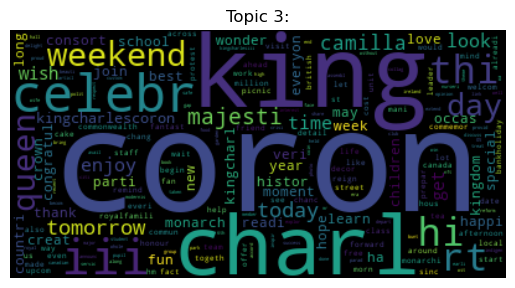

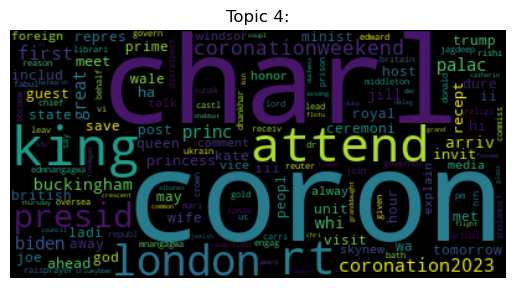

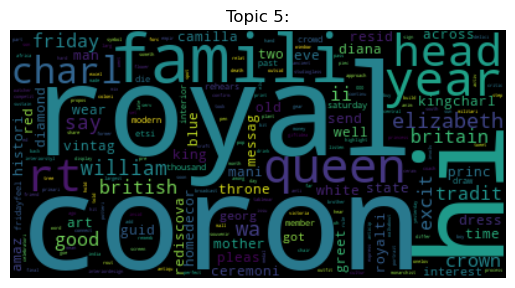

In [449]:
# Display the wordclouds
display_word_crowd(model, feature_names)